In [ ]:
# ----------------------------
# General purpose
# ----------------------------
import os
import random
import shutil
import zipfile
import pathlib
import pickle
from google.colab import drive

# ----------------------------
# Numerical and data handling
# ----------------------------
import numpy as np
import pandas as pd

# ----------------------------
# Image handling and visualization
# ----------------------------
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from tqdm import tqdm

# ----------------------------
# IPython widgets
# ----------------------------
import ipywidgets as widgets
from IPython.display import display, clear_output

# ----------------------------
# XML parsing
# ----------------------------
import xml.etree.ElementTree as ET

# ----------------------------
# Scikit-learn utilities
# ----------------------------
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report

# ----------------------------
# TensorFlow / Keras
# ----------------------------
import tensorflow as tf
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import (Dense, Flatten, Conv2D, Activation,
                                     GlobalAveragePooling2D, Dropout,
                                     BatchNormalization, AveragePooling2D,
                                     MaxPooling2D, Lambda, Multiply, Add, Resizing, Layer)
from tensorflow.keras.applications import DenseNet121, EfficientNetB0
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import register_keras_serializable, load_img, img_to_array
from tensorflow.keras.models import load_model



In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def safe_unzip(zip_path, extract_to=None):
    """
    Safely unzip a ZIP file.

    Args:
        zip_path (str): Path to the zip file.
        extract_to (str): Folder to extract to.
                          If None, extracts to same directory.

    Returns:
        str or None: Path to extracted folder if successful, otherwise None.
    """
    # Check file exists
    if not os.path.exists(zip_path):
        print(f"❌ ERROR: '{zip_path}' does not exist.")
        return None

    # Check if ZIP is valid
    if not zipfile.is_zipfile(zip_path):
        print(f"❌ ERROR: '{zip_path}' is not a valid zip file or is corrupted.")
        return None

    # Extract target folder
    if extract_to is None:
        extract_to = os.path.splitext(zip_path)[0]

    # Try to unzip
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"✅ Unzipped successfully → {extract_to}")
        return extract_to

    except Exception as e:
        print(f"❌ Unzip failed: {e}")
        return None
problem_dir = safe_unzip("/content/Problem_teeth.zip")
no_problem_dir = safe_unzip("/content/No_problem_teeth.zip")

zip_path = "/content/drive/MyDrive/tooth_labels/NO_PROBLEM_labels.zip"
extract_dir = "/content/drive/MyDrive/tooth_labels/NO_PROBLEM_labels"

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("✅ Unzipped successfully")



❌ ERROR: '/content/Problem_teeth.zip' does not exist.
❌ ERROR: '/content/No_problem_teeth.zip' does not exist.
✅ Unzipped successfully


View Images from both folders

Selected images: ['/content/drive/MyDrive/Problem_teeth/Problem_teeth/119.tif', '/content/drive/MyDrive/Problem_teeth/Problem_teeth/8.tif', '/content/drive/MyDrive/Problem_teeth/Problem_teeth/75.tif', '/content/drive/MyDrive/Problem_teeth/Problem_teeth/17.tif']
Image shape: (1480, 1948)
Image shape: (728, 960)
Image shape: (700, 948)
Image shape: (744, 956)


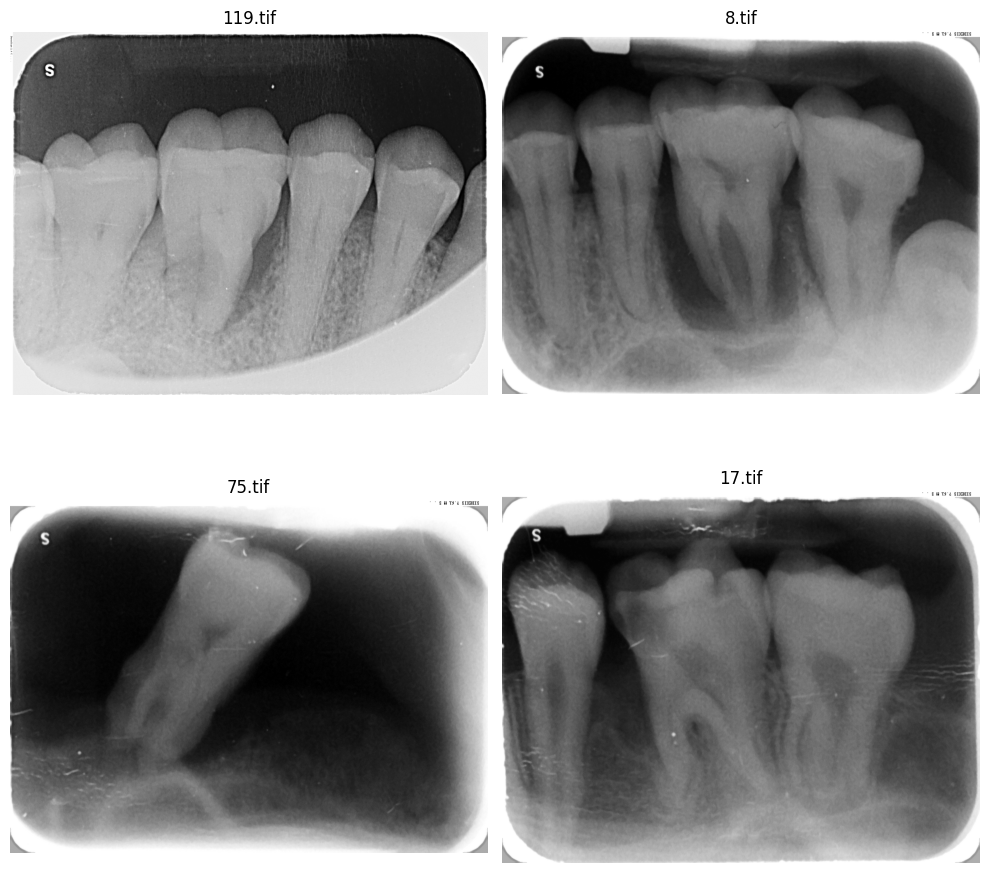

Selected images: ['/content/drive/MyDrive/No_problem_teeth/No_problem_teeth/19.tif', '/content/drive/MyDrive/No_problem_teeth/No_problem_teeth/55.tif', '/content/drive/MyDrive/No_problem_teeth/No_problem_teeth/68.tif', '/content/drive/MyDrive/No_problem_teeth/No_problem_teeth/110.tif']
Image shape: (728, 956)
Image shape: (972, 716)
Image shape: (1476, 1952)
Image shape: (1456, 1976)


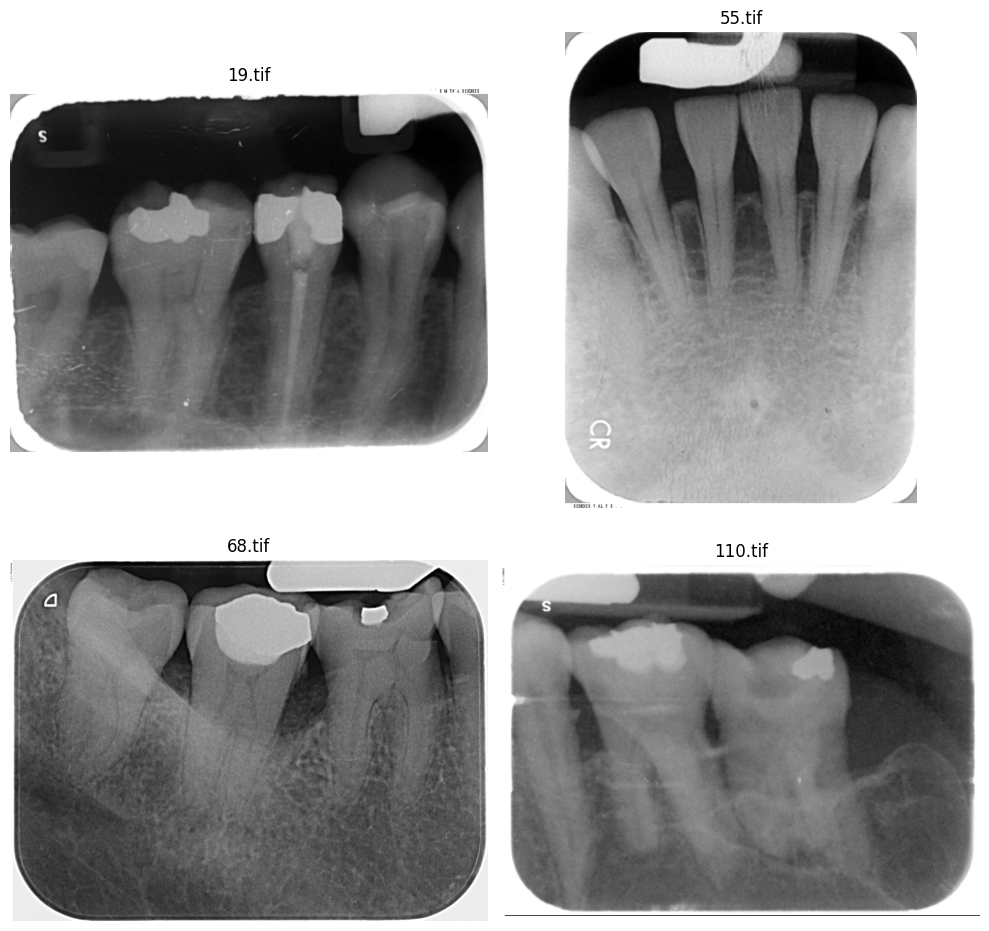

In [ ]:
def view_random_images_recursive(folder_path, num_images=4, extensions=(".tif", ".png", ".jpg")):
    """
    Display random images from a folder, recursively handling subfolders.

    Args:
        folder_path (str): Path to the folder containing images or subfolders.
        num_images (int): Number of images to display.
        extensions (tuple): Allowed image extensions.
    """
    # Recursively find all image files
    image_files = []
    for root, _, files in os.walk(folder_path):
        for f in files:
            if f.lower().endswith(extensions):
                image_files.append(os.path.join(root, f))

    if not image_files:
        print("No image files found!")
        return

    if num_images > len(image_files):
        num_images = len(image_files)

    random_images = random.sample(image_files, num_images)
    print(f"Selected images: {random_images}")

    plt.figure(figsize=(10, 10))
    for i, img_path in enumerate(random_images):
        img = mpimg.imread(img_path)
        plt.subplot(2, 2, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(os.path.basename(img_path))
        plt.axis('off')
        print(f"Image shape: {img.shape}")

    plt.tight_layout()
    plt.show()
view_random_images_recursive("/content/drive/MyDrive/Problem_teeth/Problem_teeth", num_images=4)
view_random_images_recursive("/content/drive/MyDrive/No_problem_teeth/No_problem_teeth", num_images=4)

Rotate Images to be in the same format

File: 112.tif



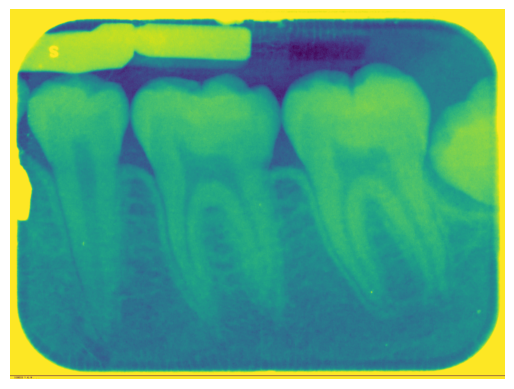

In [ ]:
# Define folders
NO_PROBLEM = "/content/drive/MyDrive/No_problem_teeth/No_problem_teeth"
PROBLEM = "/content/drive/MyDrive/Problem_teeth/Problem_teeth"

folders = [NO_PROBLEM, PROBLEM]

# Collect all image files
all_files = []
for folder in folders:
    for fname in os.listdir(folder):
        if fname.lower().endswith((".jpg", ".jpeg", ".png", ".tif")):
            all_files.append(os.path.join(folder, fname))

file_iter = iter(all_files)


def process_image(path):
    img = Image.open(path)

    def show():
        plt.imshow(img)
        plt.axis("off")
        plt.show()

    def rotate_right(_):
        nonlocal img
        img = img.rotate(-90, expand=True)
        img.save(path)
        clear_output(wait=True)
        print(f"Rotated right → {os.path.basename(path)}")
        next_image()

    def rotate_left(_):
        nonlocal img
        img = img.rotate(90, expand=True)
        img.save(path)
        clear_output(wait=True)
        print(f"Rotated left → {os.path.basename(path)}")
        next_image()

    def skip(_):
        clear_output(wait=True)
        print(f"Skipped → {os.path.basename(path)}")
        next_image()

    # Buttons
    btn_r = widgets.Button(description="Rotate Right ↪️")
    btn_l = widgets.Button(description="Rotate Left ↩️")
    btn_s = widgets.Button(description="Skip ⏭️")

    btn_r.on_click(rotate_right)
    btn_l.on_click(rotate_left)
    btn_s.on_click(skip)

    clear_output(wait=True)
    print(f"File: {os.path.basename(path)}\n")
    show()
    display(widgets.HBox([btn_r, btn_l, btn_s]))


def next_image():
    global file_iter
    try:
        process_image(next(file_iter))
    except StopIteration:
        clear_output(wait=True)
        print("✔ All images processed!")


next_image()


CLAHE preprocesing.
That’s why medical imaging papers avoid global matching.

In [ ]:
# Input folders
NO_PROBLEM = "/content/drive/MyDrive/No_problem_teeth/No_problem_teeth"
PROBLEM = "/content/drive/MyDrive/Problem_teeth/Problem_teeth"

# Output folders
NO_PROBLEM_normalized = "/content/drive/MyDrive/NO_PROBLEM_normalized"
PROBLEM_normalized = "/content/drive/MyDrive/PROBLEM_normalized"

# Pair input → output
folders = [
    (NO_PROBLEM, NO_PROBLEM_normalized),
    (PROBLEM, PROBLEM_normalized)
]

# Create output folders
for _, out_dir in folders:
    os.makedirs(out_dir, exist_ok=True)

# Create CLAHE object ONCE
clahe = cv2.createCLAHE(
    clipLimit=2.0,
    tileGridSize=(8, 8)
)

# Process images
for input_dir, output_dir in folders:
    print(f"Processing: {input_dir}")

    for img_name in tqdm(os.listdir(input_dir)):
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png", ".tif")):
            continue

        img_path = os.path.join(input_dir, img_name)

        # Read grayscale X-ray
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"⚠️ Failed to read {img_name}")
            continue

        # Apply CLAHE
        enhanced = clahe.apply(img)

        # Save
        out_path = os.path.join(output_dir, img_name)
        cv2.imwrite(out_path, enhanced)

print("✅ All images normalized with CLAHE")


Processing: /content/drive/MyDrive/No_problem_teeth/No_problem_teeth


100%|██████████| 148/148 [02:20<00:00,  1.05it/s]


Processing: /content/drive/MyDrive/Problem_teeth/Problem_teeth


100%|██████████| 154/154 [02:02<00:00,  1.26it/s]

✅ All images normalized with CLAHE


Remove 6 outlier images(different views)
Remove 2 wrong labels(normal tooth in problem folder)



In [ ]:
# Remove from BOTH folders
remove_from_both = [
    "133.tif",
    "144.tif",
    "120.tif",
    "115.tif",
    "135.tif",
    "147.tif"
]

# Remove ONLY from PROBLEM
remove_only_problem = [
    "14.tif",
    "19.tif"
]

# Paths
folders_both = [NO_PROBLEM_normalized, PROBLEM_normalized]
problem_only = PROBLEM_normalized


# ---- remove from both ----
for folder in folders_both:
    for img_name in remove_from_both:
        img_path = os.path.join(folder, img_name)
        if os.path.exists(img_path):
            os.remove(img_path)
            print(f"🗑️ Removed: {img_path}")


# ---- remove only from PROBLEM ----
for img_name in remove_only_problem:
    img_path = os.path.join(problem_only, img_name)
    if os.path.exists(img_path):
        os.remove(img_path)
        print(f"🗑️ Removed (problem only): {img_path}")

print("✅ Removal completed safely")

🗑️ Removed: /content/drive/MyDrive/NO_PROBLEM_normalized/133.tif
🗑️ Removed: /content/drive/MyDrive/NO_PROBLEM_normalized/144.tif
🗑️ Removed: /content/drive/MyDrive/NO_PROBLEM_normalized/120.tif
🗑️ Removed: /content/drive/MyDrive/NO_PROBLEM_normalized/135.tif
🗑️ Removed: /content/drive/MyDrive/NO_PROBLEM_normalized/147.tif
🗑️ Removed: /content/drive/MyDrive/PROBLEM_normalized/133.tif
🗑️ Removed: /content/drive/MyDrive/PROBLEM_normalized/144.tif
🗑️ Removed: /content/drive/MyDrive/PROBLEM_normalized/120.tif
🗑️ Removed: /content/drive/MyDrive/PROBLEM_normalized/115.tif
🗑️ Removed: /content/drive/MyDrive/PROBLEM_normalized/135.tif
🗑️ Removed: /content/drive/MyDrive/PROBLEM_normalized/147.tif
🗑️ Removed (problem only): /content/drive/MyDrive/PROBLEM_normalized/14.tif
🗑️ Removed (problem only): /content/drive/MyDrive/PROBLEM_normalized/19.tif
✅ Removal completed safely


Check the visibility difference after CLAHE

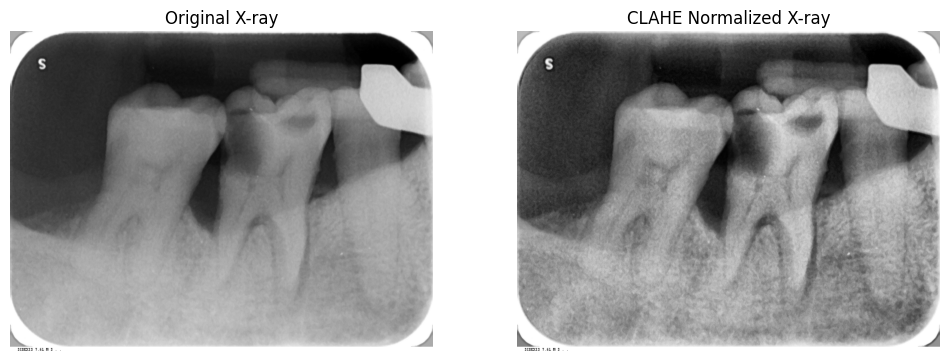

In [ ]:
# Example image
sample_image_name = "1.tif"  # replace with your actual file name

# Paths
orig_path = os.path.join("/content/drive/MyDrive/Problem_teeth/Problem_teeth", sample_image_name)
norm_path = os.path.join("/content/drive/MyDrive/PROBLEM_normalized", sample_image_name)

# Load images as grayscale
orig_img = cv2.imread(orig_path, cv2.IMREAD_GRAYSCALE)
norm_img = cv2.imread(norm_path, cv2.IMREAD_GRAYSCALE)

# Plot side by side
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("Original X-ray")
plt.imshow(orig_img, cmap="gray")
plt.axis("off")

plt.subplot(1,2,2)
plt.title("CLAHE Normalized X-ray")
plt.imshow(norm_img, cmap="gray")
plt.axis("off")

plt.show()

Assign folder prefixes to images & XML label's names
Split data into train/val/test

In [ ]:
# =====================
# CONFIG
# =====================
classes = ["NO_PROBLEM", "PROBLEM"]
image_sources = {
    "NO_PROBLEM": "/content/drive/MyDrive/NO_PROBLEM_normalized",
    "PROBLEM": "/content/drive/MyDrive/PROBLEM_normalized"
}
xml_sources = {
    "NO_PROBLEM": "/content/drive/MyDrive/tooth_labels/NO_PROBLEM_labels",
    "PROBLEM": "/content/drive/MyDrive/tooth_labels/PROBLEM_labels"
}

dataset_root = "/content/dataset"
splits = {
    "train": "train_norm",
    "val": "val_norm",
    "test": "test_norm"
}

TRAIN_RATIO = 0.77
VAL_RATIO = 0.13
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
# =====================

# Create folders
for split in splits.values():
    for cls in classes:
        os.makedirs(os.path.join(dataset_root, split, cls), exist_ok=True)
for split in splits.keys():
    os.makedirs(os.path.join(dataset_root, "annotations", split), exist_ok=True)

# =====================
# SPLIT AND COPY
# =====================
for cls in classes:
    img_folder = image_sources[cls]
    xml_folder = xml_sources[cls]

    images = [f for f in os.listdir(img_folder) if f.lower().endswith((".png",".jpg",".jpeg",".tif",".tiff"))]

    # Split into train / temp (val+test)
    train_imgs, temp_imgs = train_test_split(images, test_size=(1-TRAIN_RATIO), random_state=RANDOM_SEED)
    # Split temp into val/test
    val_ratio_adjusted = VAL_RATIO / (1-TRAIN_RATIO)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=(1-val_ratio_adjusted), random_state=RANDOM_SEED)

    split_map = {"train": train_imgs, "val": val_imgs, "test": test_imgs}

    for split_name, img_list in split_map.items():
        for img_file in img_list:
            base_name = os.path.splitext(img_file)[0]
            ext = os.path.splitext(img_file)[1]

            # Add class prefix to avoid overwriting
            new_name = f"{cls}_{base_name}.png"

            # Copy image
            src_img_path = os.path.join(img_folder, img_file)
            dst_img_path = os.path.join(dataset_root, splits[split_name], cls, new_name)
            img = cv2.imread(src_img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"⚠ Failed to read {src_img_path}")
                continue
            cv2.imwrite(dst_img_path, img)

            # Copy XML with same prefix
            src_xml_path = os.path.join(xml_folder, base_name + ".xml")
            dst_xml_path = os.path.join(dataset_root, "annotations", split_name, f"{cls}_{base_name}.xml")
            if not os.path.exists(src_xml_path):
                print(f"⚠ Missing XML: {src_xml_path}")
                continue
            shutil.copy(src_xml_path, dst_xml_path)

    print(f"{cls}: Train={len(train_imgs)} | Val={len(val_imgs)} | Test={len(test_imgs)}")

print("\n✅ Dataset split complete. Images and XMLs synchronized with class prefixes.")


NO_PROBLEM: Train=110 | Val=19 | Test=15
PROBLEM: Train=112 | Val=19 | Test=15

✅ Dataset split complete. Images and XMLs synchronized with class prefixes.


Check dataset train/val/test

In [ ]:
dataset_base = "/content/dataset"  # your dataset folder
extensions = (".png")

def check_images(dataset_dir):
    for root, dirs, files in os.walk(dataset_dir):
        img_files = [f for f in files if f.lower().endswith(extensions)]
        print(f"Folder: {root} | Images: {len(img_files)} | Subfolders: {len(dirs)}")

# Run check
check_images(dataset_base)

Folder: /content/dataset | Images: 0 | Subfolders: 4
Folder: /content/dataset/annotations | Images: 0 | Subfolders: 3
Folder: /content/dataset/annotations/train | Images: 0 | Subfolders: 0
Folder: /content/dataset/annotations/val | Images: 0 | Subfolders: 0
Folder: /content/dataset/annotations/test | Images: 0 | Subfolders: 0
Folder: /content/dataset/val_norm | Images: 0 | Subfolders: 2
Folder: /content/dataset/val_norm/NO_PROBLEM | Images: 19 | Subfolders: 0
Folder: /content/dataset/val_norm/PROBLEM | Images: 19 | Subfolders: 0
Folder: /content/dataset/train_norm | Images: 0 | Subfolders: 2
Folder: /content/dataset/train_norm/NO_PROBLEM | Images: 110 | Subfolders: 0
Folder: /content/dataset/train_norm/PROBLEM | Images: 112 | Subfolders: 0
Folder: /content/dataset/test_norm | Images: 0 | Subfolders: 2
Folder: /content/dataset/test_norm/NO_PROBLEM | Images: 15 | Subfolders: 0
Folder: /content/dataset/test_norm/PROBLEM | Images: 15 | Subfolders: 0


Set directories & rescaling for whole image training (simple)

In [ ]:
# Directories
train_dir = '/content/dataset/train_norm'
val_dir = '/content/dataset/val_norm'
test_dir = '/content/dataset/test_norm'

IMG_SIZE = (256, 256)
BATCH_SIZE = 4
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    #vertical_flip=True,  # For teeth, this can be valid
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

Load data from directories & set early stopping

In [ ]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

#Callbacks
# -------------------------------
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_simple_teeth_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)
print(f"Training samples: {train_data.samples}")
print(f"Validation samples: {val_data.samples}")
print(f"Test samples: {test_data.samples}")

Found 222 images belonging to 2 classes.
Found 38 images belonging to 2 classes.
Found 30 images belonging to 2 classes.
Training samples: 222
Validation samples: 38
Test samples: 30


View few images from both classes before training

In [ ]:
def view_random_images(target_dir, target_class, num_images=4):

    target_dir = target_dir.rstrip("/")

    base_folder = os.path.join(target_dir, target_class)

    # If nested folder with same name exists:
    nested_folder = os.path.join(base_folder, target_class)
    if os.path.exists(nested_folder):
        print(f"📁 Nested folder detected → using: {nested_folder}")
        target_folder = nested_folder
    else:
        target_folder = base_folder

    all_images = [f for f in os.listdir(target_folder)
                  if f.lower().endswith((".jpg", ".jpeg", ".png", ".tif"))]

    if len(all_images) == 0:
        print(f"❌ No images found in {target_folder}")
        return []

    if num_images > len(all_images):
        print(f"⚠️ Only {len(all_images)} images available. Showing all.")
        num_images = len(all_images)

    random_images = random.sample(all_images, num_images)
    print("Selected:", random_images)

    plt.figure(figsize=(10, 10))

    for i, img_name in enumerate(random_images):
        img_path = os.path.join(target_folder, img_name)

        img = mpimg.imread(img_path)
        plt.subplot(2, 2, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(img_name)
        plt.axis("off")

    plt.tight_layout()
    plt.show()
view_random_images(train_dir, "NO_PROBLEM", 4)
view_random_images(train_dir, "PROBLEM", 4)
view_random_images(test_dir, "NO_PROBLEM", 4)
view_random_images(test_dir, "PROBLEM", 4)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
model_1 = Sequential([
    Conv2D(32, (3,3), activation="relu", padding="same",
           input_shape=(224,224,3)),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, (3,3), activation="relu", padding="same",
           kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, (3,3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile model
# -------------------------------
model_1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,785 (432.75 KB)

 Trainable params: 110,337 (431.00 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
history_1 = model_1.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.5392 - loss: 0.8122
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_simple_teeth_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 253ms/step - accuracy: 0.5389 - loss: 0.8113 - val_accuracy: 0.5000 - val_loss: 0.7228 - learning_rate: 0.0010
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.5248 - loss: 0.7164
Epoch 2: val_accuracy did not improve from 0.50000
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 0.5250 - loss: 0.7165 - val_accuracy: 0.3947 - val_loss: 0.7281 - learning_rate: 0.0010
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.5674 - loss: 0.6874
Epoch 3: val_accuracy did not improve from 0.50000
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.5680 - loss: 0.6873 - val_accuracy: 0.5000 - val_loss: 0.7569 - learning_rate: 0.0010
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5474 - loss: 0.7115
Epoch 4: val_accuracy did n

Result 1 of training full images with scratch CNNs

In [ ]:
scratch_CNNs = model_1.evaluate(test_data)
print(f"\nTest Loss: {scratch_CNNs[0]:.4f}")
print(f"Test Accuracy: {scratch_CNNs[1]:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.5304 - loss: 0.8579

Test Loss: 0.7683
Test Accuracy: 0.6000


Transfer learning with DenseNet121 pretrained model for full images

In [ ]:
base_model = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=(256,256,3)
)

base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)

model_2 = Model(inputs=base_model.input, outputs=output)
model_2.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 262, 262,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 64, 64,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 64, 64,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 64, 64,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 64, 64,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 64, 64,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 64, 64,    │     12,288 │ conv2_block2_0_r

 Total params: 7,168,833 (27.35 MB)

 Trainable params: 131,329 (513.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
checkpoint = ModelCheckpoint(
    'best_imagenet_teeth_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)
model_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history_2 = model_2.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.4637 - loss: 0.8329
Epoch 1: val_accuracy improved from -inf to 0.44737, saving model to best_imagenet_teeth_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 68s 756ms/step - accuracy: 0.4639 - loss: 0.8328 - val_accuracy: 0.4474 - val_loss: 0.7075 - learning_rate: 1.0000e-04
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5695 - loss: 0.7685
Epoch 2: val_accuracy improved from 0.44737 to 0.55263, saving model to best_imagenet_teeth_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - accuracy: 0.5695 - loss: 0.7683 - val_accuracy: 0.5526 - val_loss: 0.6430 - learning_rate: 1.0000e-04
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.5528 - loss: 0.7500
Epoch 3: val_accuracy improved from 0.55263 to 0.65789, saving model to best_imagenet_teeth_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 181ms/step - accuracy: 0.5529 - loss: 0.7496 - val_accuracy: 0.6579 - val_loss: 0.6199 - learning_rate: 1.0

Result 2 of training full images with transfer learning

In [ ]:
test_base = model_2.evaluate(test_data)
print(f"\nTest Loss: {test_base[0]:.4f}")
print(f"Test Accuracy: {test_base[1]:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.7627 - loss: 0.4596

Test Loss: 0.5513
Test Accuracy: 0.7000


Plot the accuracy and loss curves for training and validation

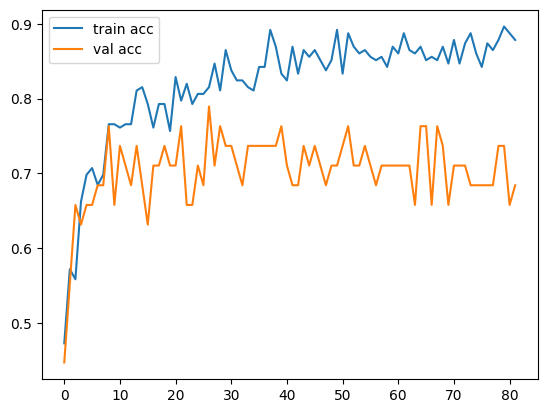

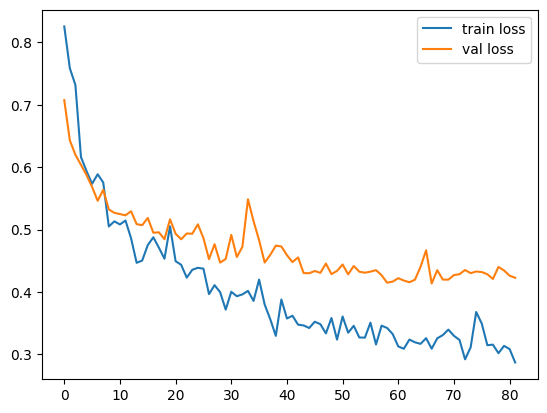

In [ ]:
plt.plot(history_2.history['accuracy'], label='train acc')
plt.plot(history_2.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

plt.plot(history_2.history['loss'], label='train loss')
plt.plot(history_2.history['val_loss'], label='val loss')
plt.legend()
plt.show()

Check if there are duplicate files between training and validation set

In [ ]:
def get_all_images(base_dir):
    images = set()
    for root, _, files in os.walk(base_dir):
        for f in files:
            if f.lower().endswith((".png", ".jpg", ".jpeg", ".tif")):
                images.add(f)  # filename only
    return images

train_images = get_all_images("/content/dataset/train_norm")
val_images   = get_all_images("/content/dataset/val_norm")

overlap = train_images & val_images

print("Overlapping image files:", overlap)
print("Number of overlaps:", len(overlap))


Overlapping image files: set()
Number of overlaps: 0


Grad-Cam detection heatmap to see where the model look at in the last CNN layer

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_1']]
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


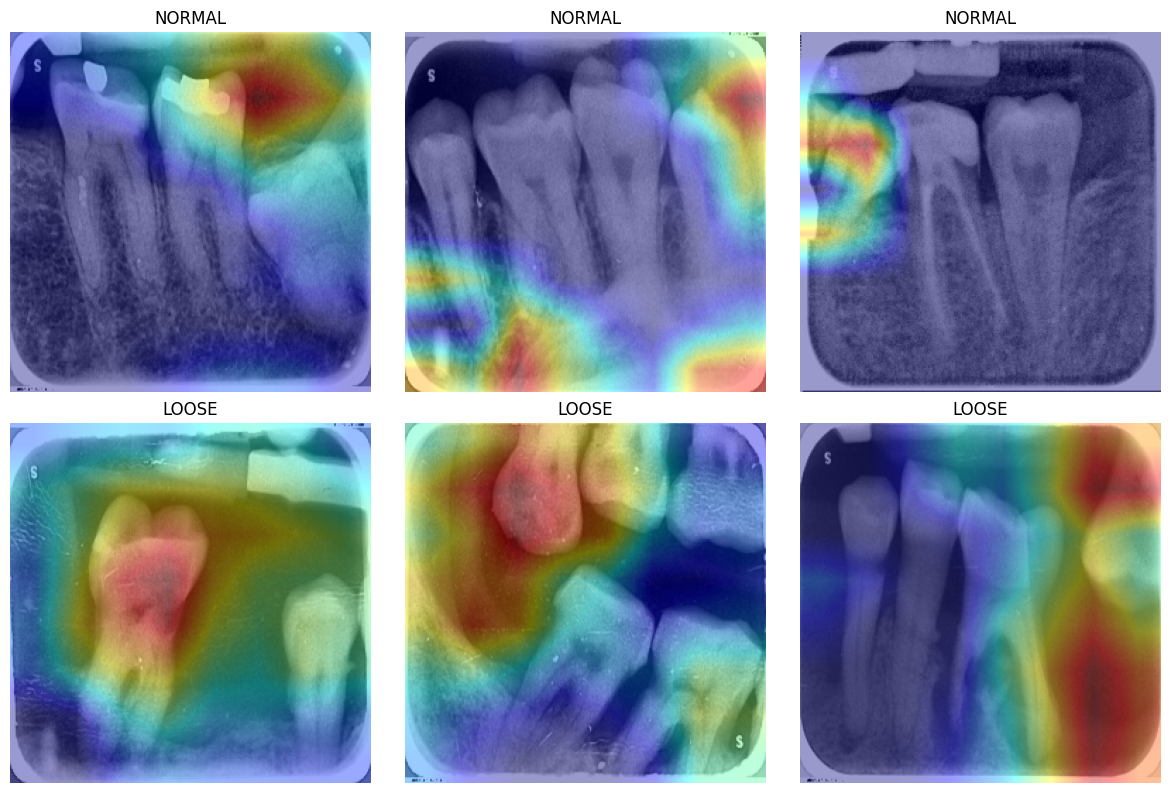

In [ ]:
def generate_gradcam(model, img_path, last_conv_layer_name):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256,256))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]  # binary classifier

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()

    img = cv2.imread(img_path)
    img = cv2.resize(img, (256,256))

    heatmap = cv2.resize(heatmap, (256,256))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    return cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

model = tf.keras.models.load_model("best_imagenet_teeth_model.keras")
last_conv_layer_name = "conv5_block16_concat"

normal_dir = "/content/dataset/train_norm/NO_PROBLEM"
loose_dir = "/content/dataset/train_norm/PROBLEM"

normal_imgs = random.sample(os.listdir(normal_dir), 3)
loose_imgs = random.sample(os.listdir(loose_dir), 3)

plt.figure(figsize=(12, 8))

# NORMAL teeth
for i, img_name in enumerate(normal_imgs):
    img_path = os.path.join(normal_dir, img_name)
    gradcam_img = generate_gradcam(model, img_path, last_conv_layer_name)

    plt.subplot(2, 3, i+1)
    plt.imshow(gradcam_img)
    plt.title("NORMAL")
    plt.axis("off")

# LOOSE teeth
for i, img_name in enumerate(loose_imgs):
    img_path = os.path.join(loose_dir, img_name)
    gradcam_img = generate_gradcam(model, img_path, last_conv_layer_name)

    plt.subplot(2, 3, i+4)
    plt.imshow(gradcam_img)
    plt.title("LOOSE")
    plt.axis("off")

plt.tight_layout()
plt.show()


Create an attention model with ROI masks

In [ ]:
class AttentionGuidedGenerator(tf.keras.utils.Sequence):
    def __init__(
        self,
        data_source,
        ann_dir=None,
        batch_size=4,
        img_size=(256, 256),
        shuffle=True,
        **kwargs
    ):
        """
        data_source:
            - str  → image directory (NO_PROBLEM / PROBLEM)
            - list → [(img_path, xml_path, label), ...]  (for CV)
        ann_dir:
            - required ONLY if data_source is str
        """
        super().__init__(**kwargs)

        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle

        # -------------------------------
        # Case 1: Cross-validation list
        # -------------------------------
        if isinstance(data_source, list):
            self.samples = data_source

        # -------------------------------
        # Case 2: Directory-based dataset
        # -------------------------------
        elif isinstance(data_source, str):
            if ann_dir is None:
                raise ValueError("ann_dir must be provided when using directory input")

            self.samples = []
            for class_name in ['NO_PROBLEM', 'PROBLEM']:
                class_dir = os.path.join(data_source, class_name)
                label = 0 if class_name == 'NO_PROBLEM' else 1

                if not os.path.isdir(class_dir):
                    continue

                for img_file in os.listdir(class_dir):
                    if not img_file.lower().endswith('.png'):
                        continue

                    img_path = os.path.join(class_dir, img_file)
                    xml_path = os.path.join(
                        ann_dir, img_file.replace('.png', '.xml')
                    )

                    if os.path.exists(xml_path):
                        self.samples.append((img_path, xml_path, label))
        else:
            raise ValueError("data_source must be a directory path or a list")

        if len(self.samples) == 0:
            raise ValueError("No samples found")

        self.indexes = np.arange(len(self.samples))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.samples) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[
            index * self.batch_size:(index + 1) * self.batch_size
        ]
        batch_samples = [self.samples[i] for i in batch_indexes]

        images, masks, labels = [], [], []

        for img_path, xml_path, label in batch_samples:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            original_shape = img.shape

            img = cv2.resize(img, self.img_size)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            img = img.astype(np.float32) / 255.0
            images.append(img)

            mask = self._create_attention_mask(xml_path, original_shape)
            masks.append(mask)

            labels.append(label)

        return (np.array(images), np.array(masks)), np.array(labels)

    def _create_attention_mask(self, xml_path, original_shape):
        mask = np.zeros(original_shape, dtype=np.float32)

        try:
            tree = ET.parse(xml_path)
            root = tree.getroot()
            for obj in root.findall('object'):
                bbox = obj.find('bndbox')
                xmin = int(bbox.find('xmin').text)
                ymin = int(bbox.find('ymin').text)
                xmax = int(bbox.find('xmax').text)
                ymax = int(bbox.find('ymax').text)
                mask[ymin:ymax, xmin:xmax] = 1.0
        except Exception:
            pass

        mask = cv2.resize(mask, self.img_size)
        return np.expand_dims(mask, axis=-1)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [ ]:
@register_keras_serializable(package='Custom', name='ScaleLayer')
class ScaleLayer(Layer):
    def __init__(self, scale, **kwargs):
        super().__init__(**kwargs)
        self.scale = scale

    def call(self, inputs):
        return inputs * self.scale

    def get_config(self):
        config = super().get_config()
        config.update({"scale": self.scale})
        return config

In [ ]:
# ----------------------------
# 2️⃣ Build Attention Model (DenseNet121 frozen initially)
# ----------------------------
def build_attention_model():
    img_input = Input(shape=(256, 256, 3), name='image')
    attention_mask = Input(shape=(256, 256, 1), name='attention_mask')

    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_tensor=img_input
    )
    base_model.trainable = False  # initially frozen

    features = base_model.output

    # Learned attention
    attention_weights = Conv2D(1, (1, 1), activation='sigmoid', name='learned_attention')(features)

    # Resize guided attention
    attention_mask_resized = Resizing(features.shape[1], features.shape[2], name="resize_attention_mask")(attention_mask)

    # Scale attentions
    learned_attn_scaled = ScaleLayer(0.2, name="scale_learned_attn")(attention_weights)
    guided_attn_scaled = ScaleLayer(0.8, name="scale_guided_attn")(attention_mask_resized)

    # Combine attentions
    combined_attention = Add(name="combine_attention")([learned_attn_scaled, guided_attn_scaled])
    attended_features = Multiply(name="apply_attention")([features, combined_attention])

    # Classification head
    x = GlobalAveragePooling2D()(attended_features)
    x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.65)(x)     # Single high dropout
    output = Dense(1, activation='sigmoid')(x)

    return Model(inputs=[img_input, attention_mask], outputs=output), base_model

Set directories for attention training (attention model)

In [ ]:
train_dir = '/content/dataset/train_norm'
val_dir   = '/content/dataset/val_norm'
test_dir  = '/content/dataset/test_norm'

train_ann = '/content/dataset/annotations/train'
val_ann   = '/content/dataset/annotations/val'
test_ann  = '/content/dataset/annotations/test'

IMG_SIZE = (256, 256)
BATCH_SIZE = 4

train_gen_attn = AttentionGuidedGenerator(
    train_dir,
    train_ann,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    shuffle=True
)

val_gen_attn = AttentionGuidedGenerator(
    val_dir,
    val_ann,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    shuffle=False
)

test_gen_attn = AttentionGuidedGenerator(
    test_dir,
    test_ann,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    shuffle=False
)


In [ ]:
print("Train samples:", len(train_gen_attn.samples))
print("Val samples:  ", len(val_gen_attn.samples))
print("Test samples: ", len(test_gen_attn.samples))

(x_img, x_mask), y = train_gen_attn[0]
print(x_img.shape, x_mask.shape, y.shape)


Train samples: 222
Val samples:   38
Test samples:  30
(4, 256, 256, 3) (4, 256, 256, 1) (4,)


In [ ]:
# ----------------------------
# 3️⃣ Instantiate model
# ----------------------------
attention_model, base_model = build_attention_model()

attention_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8),
    ModelCheckpoint('best_attention_teeth_model.keras',
                    monitor='val_accuracy', save_best_only=True)
]

history_attn = attention_model.fit(
    train_gen_attn,
    validation_data=val_gen_attn,
    epochs=100,
    callbacks=callbacks
)


Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 60s 649ms/step - accuracy: 0.5286 - loss: 0.7228 - val_accuracy: 0.6053 - val_loss: 0.6964 - learning_rate: 1.0000e-04
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.6063 - loss: 0.6648 - val_accuracy: 0.7105 - val_loss: 0.6758 - learning_rate: 1.0000e-04
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.6885 - loss: 0.6355 - val_accuracy: 0.6842 - val_loss: 0.6508 - learning_rate: 1.0000e-04
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.6863 - loss: 0.6175 - val_accuracy: 0.7368 - val_loss: 0.6367 - learning_rate: 1.0000e-04
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.7251 - loss: 0.5812 - val_accuracy: 0.7368 - val_loss: 0.6219 - learning_rate: 1.0000e-04
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.6950 - loss: 0.5798 - val_accuracy: 0.7368 - val_loss: 0.6036 - learning_rate: 1.0000e-04
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accurac

Result 3 of training with ROI masks and transfer learning

In [ ]:
test_results = attention_model.evaluate(test_gen_attn)
print(f"\n🦷 Attention-Guided Test Accuracy: {test_results[1]:.4f}") #0.83

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.8591 - loss: 0.3649

🦷 Attention-Guided Test Accuracy: 0.7667


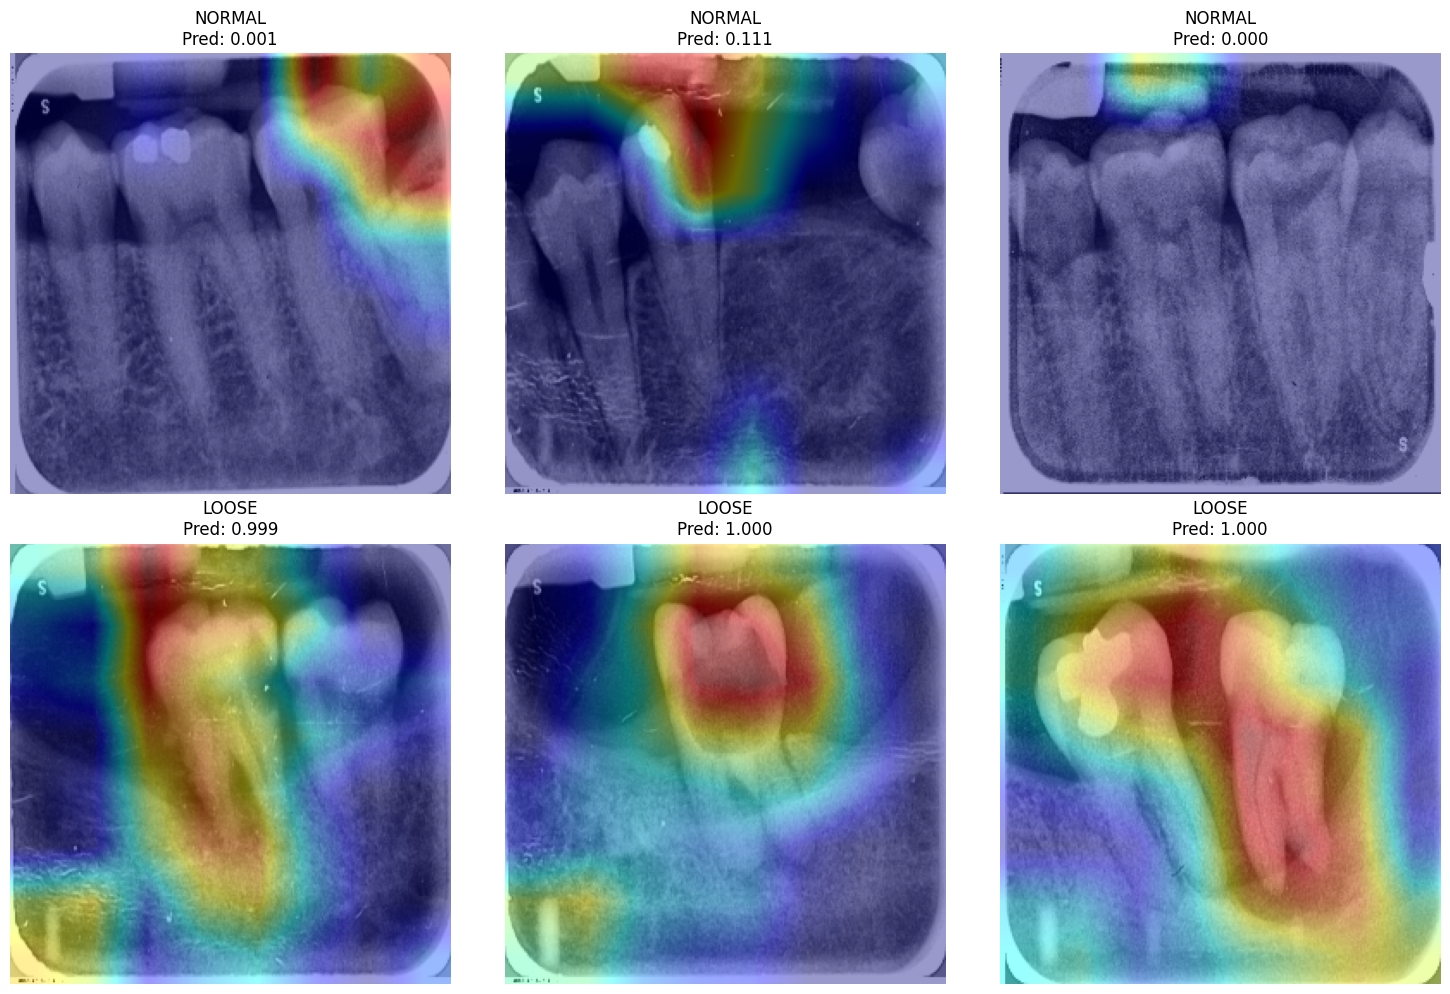

In [ ]:
# Load your trained attention model
model = load_model(
    "best_attention_teeth_model.keras",
    custom_objects={"ScaleLayer": ScaleLayer},
    compile=False
)

last_conv_layer_name = "conv5_block16_concat"

# Parse XML ROI function
def parse_xml_roi(xml_path):
    """Extract bounding boxes from XML annotation file"""
    tree = ET.parse(xml_path)
    root = tree.getroot()

    boxes = []
    for obj in root.findall('object'):
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        boxes.append((xmin, ymin, xmax, ymax))

    return boxes

# Enhanced Grad-CAM with ROI
def generate_gradcam_with_roi(model, img_path, xml_path, last_conv_layer_name):
    """Generate Grad-CAM with ROI boxes overlaid"""

    # Load & preprocess image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Dummy attention mask
    attention_mask = np.ones((1, 256, 256, 1), dtype=np.float32)

    # Grad-CAM model
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[
            model.get_layer(last_conv_layer_name).output,
            model.output
        ]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model([img_array, attention_mask])
        loss = predictions[:, 0]

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    # Normalize heatmap
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + 1e-8
    heatmap = heatmap.numpy()

    # Load original image and resize
    img_original = cv2.imread(img_path)
    original_h, original_w = img_original.shape[:2]
    img_resized = cv2.resize(img_original, (256, 256))

    # Create heatmap overlay
    heatmap_resized = cv2.resize(heatmap, (256, 256))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img_resized, 0.6, heatmap_colored, 0.4, 0)

    # Parse and draw ROI boxes
    if xml_path and os.path.exists(xml_path):
        boxes = parse_xml_roi(xml_path)

        for (xmin, ymin, xmax, ymax) in boxes:
            # Scale coordinates to 256x256
            xmin_scaled = int(xmin * 256 / original_w)
            ymin_scaled = int(ymin * 256 / original_h)
            xmax_scaled = int(xmax * 256 / original_w)
            ymax_scaled = int(ymax * 256 / original_h)

            # Draw green rectangle for ROI
            cv2.rectangle(
                superimposed_img,
                (xmin_scaled, ymin_scaled),
                (xmax_scaled, ymax_scaled),
                (0, 255, 0),  # Green color
                2  # Thickness
            )

    return cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB), predictions[0][0].numpy()

# Visualization
normal_dir = "/content/dataset/train_norm/NO_PROBLEM"
loose_dir = "/content/dataset/train_norm/PROBLEM"

normal_imgs = random.sample(os.listdir(normal_dir), 3)
loose_imgs = random.sample(os.listdir(loose_dir), 3)

plt.figure(figsize=(15, 10))

# NORMAL teeth
for i, img_name in enumerate(normal_imgs):
    img_path = os.path.join(normal_dir, img_name)
    xml_path = img_path.replace('.jpg', '.xml').replace('.png', '.xml')

    gradcam_img, pred = generate_gradcam_with_roi(
        model, img_path, xml_path, last_conv_layer_name
    )

    plt.subplot(2, 3, i + 1)
    plt.imshow(gradcam_img)
    plt.title(f"NORMAL\nPred: {pred:.3f}")
    plt.axis("off")

# LOOSE teeth
for i, img_name in enumerate(loose_imgs):
    img_path = os.path.join(loose_dir, img_name)
    xml_path = img_path.replace('.jpg', '.xml').replace('.png', '.xml')

    gradcam_img, pred = generate_gradcam_with_roi(
        model, img_path, xml_path, last_conv_layer_name
    )

    plt.subplot(2, 3, i + 4)
    plt.imshow(gradcam_img)
    plt.title(f"LOOSE\nPred: {pred:.3f}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# ----------------------------
# 4️⃣ Fine-tuning: unfreeze ONLY 1 layer
# ----------------------------

# Freeze everything
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze ONLY the last layer
last_layer = base_model.layers[-1]

if isinstance(last_layer, BatchNormalization):
    last_layer.trainable = False  # safety
else:
    last_layer.trainable = True

print("Unfrozen layer:", last_layer.name)


# ----------------------------
# 5️⃣ Optional: check trainable layers
# ----------------------------
trainable_count = sum([1 for layer in base_model.layers if layer.trainable])
print(f"Number of trainable layers: {trainable_count}")

# ----------------------------
# 6️⃣ Compile the model after changing trainable layers
# ----------------------------

attention_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# ----------------------------
# 7️⃣ Fine-tune
# ----------------------------
history_finetune = attention_model.fit(
    train_gen_attn,
    validation_data=val_gen_attn,
    epochs=100,
    callbacks=callbacks
)


Unfrozen layer: relu
Number of trainable layers: 1
Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 59s 643ms/step - accuracy: 0.9362 - loss: 0.1948 - val_accuracy: 0.9211 - val_loss: 0.3159 - learning_rate: 5.0000e-06
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.9389 - loss: 0.1836 - val_accuracy: 0.9211 - val_loss: 0.3161 - learning_rate: 5.0000e-06
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.9509 - loss: 0.1818 - val_accuracy: 0.9211 - val_loss: 0.3168 - learning_rate: 5.0000e-06
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.9450 - loss: 0.1644 - val_accuracy: 0.8947 - val_loss: 0.3178 - learning_rate: 5.0000e-06
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.9614 - loss: 0.1669 - val_accuracy: 0.8684 - val_loss: 0.3188 - learning_rate: 5.0000e-06
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.9831 - loss: 0.1217 - val_accuracy: 0.8684 - val_loss: 0.3193 - learning_rate: 5.0000e-06
Epoch 7/100

Result 4 of ROI attention fine tuning the blackbone

In [ ]:
finetuned_attn_model = attention_model.evaluate(test_gen_attn)
print(f"\n🦷 Attention-Guided Test Accuracy: {test_results[1]:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.8704 - loss: 0.3779

🦷 Attention-Guided Test Accuracy: 0.7667


Check accuracy with ROI masked black out

In [ ]:
class AttentionGuidedMaskedGenerator(AttentionGuidedGenerator):
    def __getitem__(self, index):
        batch_indexes = self.indexes[
            index * self.batch_size:(index + 1) * self.batch_size
        ]
        batch_samples = [self.samples[i] for i in batch_indexes]

        images, masks, labels = [], [], []

        for img_path, xml_path, label in batch_samples:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue

            original_shape = img.shape

            # Image preprocessing (same as parent)
            img = cv2.resize(img, self.img_size)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            img = img.astype(np.float32) / 255.0

            # Attention mask (same as parent)
            mask = self._create_attention_mask(xml_path, original_shape)
            mask_bin = (mask > 0.5).astype(np.float32)

            # 🔴 ONLY DIFFERENCE: BLACK OUT ROI
            img = img * (1.0 - mask_bin)

            images.append(img)
            masks.append(mask)
            labels.append(label)

        return (np.array(images), np.array(masks)), np.array(labels)


Image shape: (4, 256, 256, 3)
Mask shape:  (4, 256, 256, 1)
Labels shape: (4,)
ROI mean: 0.0
BG mean : 0.56511456


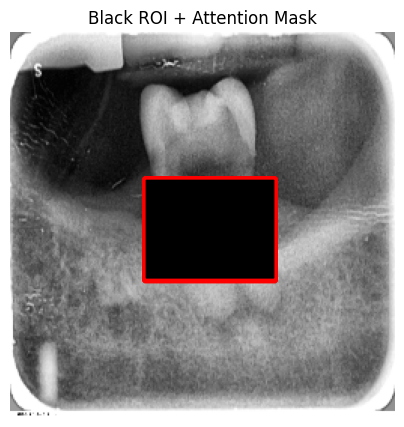

In [ ]:
train_gen_masked = AttentionGuidedMaskedGenerator(
    train_dir,
    train_ann,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    shuffle=True
)

val_gen_masked = AttentionGuidedMaskedGenerator(
    val_dir,
    val_ann,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    shuffle=False
)

test_gen_masked = AttentionGuidedMaskedGenerator(
    test_dir,
    test_ann,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    shuffle=False
)
(x_img, x_mask), y = train_gen_masked[0]

print("Image shape:", x_img.shape)
print("Mask shape: ", x_mask.shape)
print("Labels shape:", y.shape)

roi_pixels = x_img[x_mask.squeeze() > 0.5]
bg_pixels  = x_img[x_mask.squeeze() <= 0.5]

print("ROI mean:", roi_pixels.mean())
print("BG mean :", bg_pixels.mean())

import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.imshow(x_img[0])
plt.contour(x_mask[0].squeeze(), colors='red')
plt.title("Black ROI + Attention Mask")
plt.axis('off')
plt.show()


Result 5 with masked out inside ROI if the accuracy dropped

In [ ]:
masked_test_results = attention_model.evaluate(test_gen_masked)

print(f"Accuracy (same model, ROI masked): {masked_test_results[1]:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.3350 - loss: 1.4113
Accuracy (same model, ROI masked): 0.5333


Split data into train/test/val for cropped images ROI model

In [ ]:
# =====================
# CONFIG
# =====================
classes = ["NO_PROBLEM", "PROBLEM"]

image_sources = {
    "NO_PROBLEM": "/content/drive/MyDrive/NO_PROBLEM_normalized",
    "PROBLEM": "/content/drive/MyDrive/PROBLEM_normalized"
}

xml_sources = {
    "NO_PROBLEM": "/content/drive/MyDrive/tooth_labels/NO_PROBLEM_labels",
    "PROBLEM": "/content/drive/MyDrive/tooth_labels/PROBLEM_labels"
}

dataset_root = "/content/dataset_cropped"

splits = {
    "train": "train_crop",
    "val": "val_crop",
    "test": "test_crop"
}

TRAIN_RATIO = 0.77
VAL_RATIO = 0.13
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# =====================
# CREATE OUTPUT DIRS
# =====================
for split in splits.values():
    for cls in classes:
        os.makedirs(os.path.join(dataset_root, split, cls), exist_ok=True)

# =====================
# XML PARSER (Pascal VOC)
# =====================
def parse_voc_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    boxes = []
    for obj in root.findall("object"):
        bnd = obj.find("bndbox")
        xmin = int(float(bnd.find("xmin").text))
        ymin = int(float(bnd.find("ymin").text))
        xmax = int(float(bnd.find("xmax").text))
        ymax = int(float(bnd.find("ymax").text))
        boxes.append((xmin, ymin, xmax, ymax))

    return boxes

# =====================
# SPLIT + CROP
# =====================
for cls in classes:
    img_folder = image_sources[cls]
    xml_folder = xml_sources[cls]

    images = [f for f in os.listdir(img_folder)
              if f.lower().endswith((".png", ".jpg", ".jpeg", ".tif", ".tiff"))]

    # Train / temp
    train_imgs, temp_imgs = train_test_split(
        images, test_size=(1 - TRAIN_RATIO), random_state=RANDOM_SEED
    )

    # Val / test
    val_ratio_adjusted = VAL_RATIO / (1 - TRAIN_RATIO)
    val_imgs, test_imgs = train_test_split(
        temp_imgs, test_size=(1 - val_ratio_adjusted), random_state=RANDOM_SEED
    )

    split_map = {
        "train": train_imgs,
        "val": val_imgs,
        "test": test_imgs
    }

    for split_name, img_list in split_map.items():
        for img_file in img_list:
            base_name = os.path.splitext(img_file)[0]

            img_path = os.path.join(img_folder, img_file)
            xml_path = os.path.join(xml_folder, base_name + ".xml")

            if not os.path.exists(xml_path):
                print(f"⚠ Missing XML: {xml_path}")
                continue

            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"⚠ Failed to read image: {img_path}")
                continue

            h, w = img.shape
            boxes = parse_voc_xml(xml_path)

            for i, (xmin, ymin, xmax, ymax) in enumerate(boxes):
                # Safety clamp
                xmin = max(0, xmin)
                ymin = max(0, ymin)
                xmax = min(w, xmax)
                ymax = min(h, ymax)

                if xmax <= xmin or ymax <= ymin:
                    continue

                crop = img[ymin:ymax, xmin:xmax]

                out_name = f"{cls}_{base_name}_roi_{i}.png"
                out_path = os.path.join(
                    dataset_root, splits[split_name], cls, out_name
                )

                cv2.imwrite(out_path, crop)

    print(f"{cls}: Train={len(train_imgs)} | Val={len(val_imgs)} | Test={len(test_imgs)}")

print("\n✅ Cropped ROI dataset created successfully")


NO_PROBLEM: Train=110 | Val=19 | Test=15
PROBLEM: Train=112 | Val=19 | Test=15

✅ Cropped ROI dataset created successfully


Split data for cropped ROI model

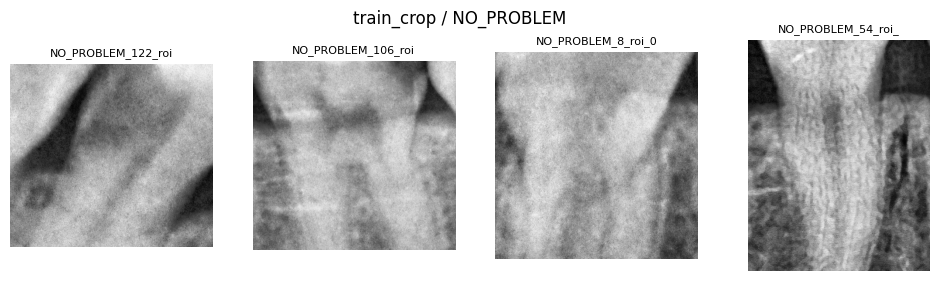

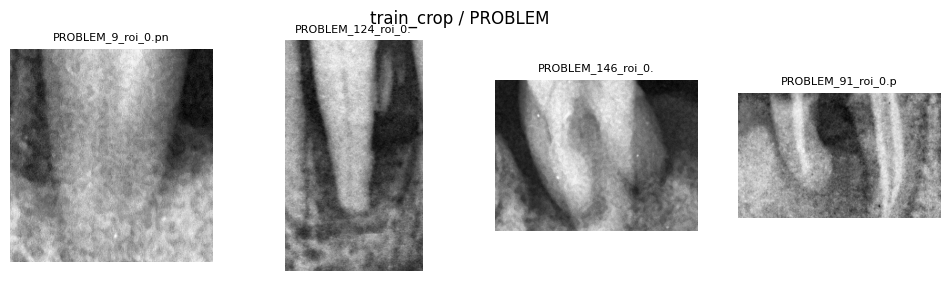

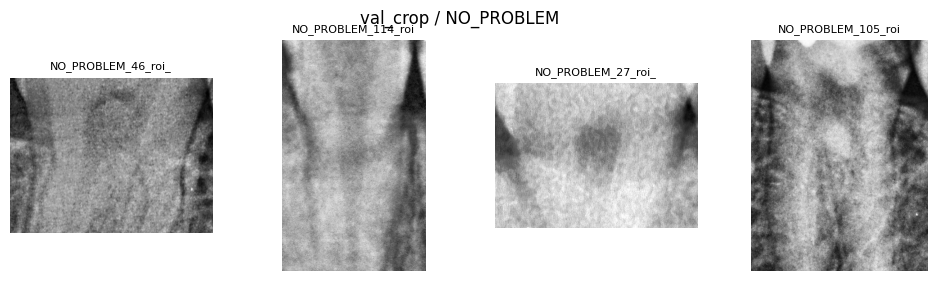

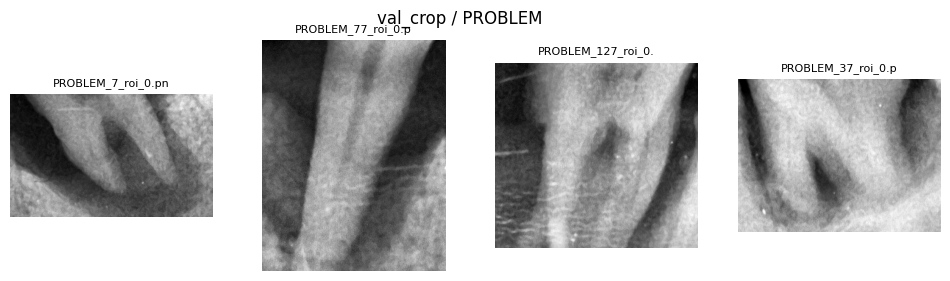

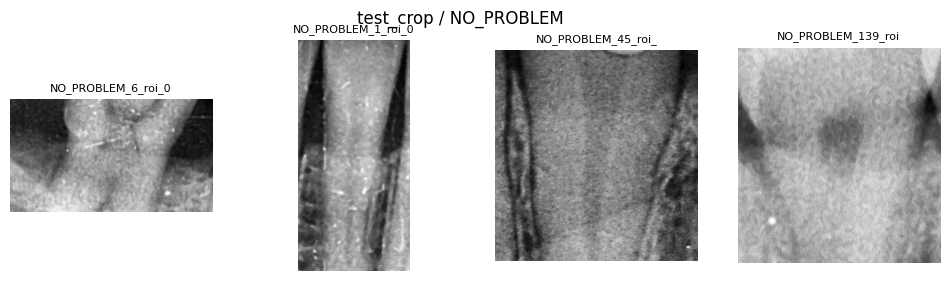

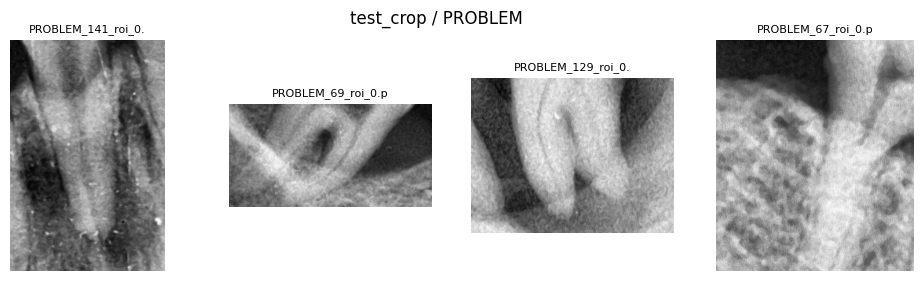

In [ ]:
# =====================
# CONFIG
# =====================
dataset_root = "/content/dataset_cropped"
splits = ["train_crop", "val_crop", "test_crop"]
classes = ["NO_PROBLEM", "PROBLEM"]
NUM_IMAGES = 4   # show 4 at once

# =====================
# SHOW IMAGES (4 AT ONCE)
# =====================
for split in splits:
    for cls in classes:
        folder = os.path.join(dataset_root, split, cls)

        if not os.path.exists(folder):
            print(f"Missing folder: {folder}")
            continue

        images = [f for f in os.listdir(folder)
                  if f.lower().endswith((".png", ".jpg", ".jpeg"))]

        if len(images) == 0:
            print(f"No images in {folder}")
            continue

        sample_imgs = random.sample(images, min(NUM_IMAGES, len(images)))

        fig, axes = plt.subplots(1, len(sample_imgs), figsize=(12, 3))
        fig.suptitle(f"{split} / {cls}")

        if len(sample_imgs) == 1:
            axes = [axes]

        for ax, img_name in zip(axes, sample_imgs):
            img_path = os.path.join(folder, img_name)
            img = Image.open(img_path)

            ax.imshow(img, cmap="gray")
            ax.axis("off")
            ax.set_title(img_name[:18], fontsize=8)

        plt.show()


In [ ]:
# Directories
train_crop_dir = '/content/dataset_cropped/train_crop'
val_crop_dir = '/content/dataset_cropped/val_crop'
test_crop_dir = '/content/dataset_cropped/test_crop'

IMG_SIZE = (256, 256)
BATCH_SIZE = 4
train_crop_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    #vertical_flip=True,  # For teeth, this can be valid
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_crop_datagen = ImageDataGenerator(rescale=1./255)
test_crop_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_crop_data = train_crop_datagen.flow_from_directory(
    train_crop_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True
)

val_crop_data = val_crop_datagen.flow_from_directory(
    val_crop_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

test_crop_data = test_crop_datagen.flow_from_directory(
    test_crop_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

Found 222 images belonging to 2 classes.
Found 38 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


In [ ]:
# COMPILE MODEL
# =====================
inputs = Input(shape=(256, 256, 3))

base_model = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_tensor=inputs
)
base_model.trainable = False

x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation="sigmoid")(x)

model_3 = Model(inputs, outputs)

checkpointearly_stop = ModelCheckpoint(
    filepath="best_cropped_teeth_model.keras",  # <-- set checkpoint filename here
    monitor='val_loss',      # or 'val_accuracy'
    verbose=1,
    save_weights_only=False, # save full model
    mode='auto'
)

model_3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# =====================
# TRAIN MODEL
# =====================
history_3 = model_3.fit(
    train_crop_data,
    validation_data=val_crop_data,
    epochs=100,
    callbacks=[checkpointearly_stop, reduce_lr, early_stop]
)

Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.5909 - loss: 0.7554
Epoch 1: saving model to best_cropped_teeth_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 63s 694ms/step - accuracy: 0.5898 - loss: 0.7558 - val_accuracy: 0.4737 - val_loss: 0.7234 - learning_rate: 1.0000e-04
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5327 - loss: 0.7482
Epoch 2: saving model to best_cropped_teeth_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.5331 - loss: 0.7474 - val_accuracy: 0.6316 - val_loss: 0.6378 - learning_rate: 1.0000e-04
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6645 - loss: 0.6626
Epoch 3: saving model to best_cropped_teeth_model.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.6642 - loss: 0.6623 - val_accuracy: 0.7105 - val_loss: 0.6289 - learning_rate: 1.0000e-04
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7194 - loss: 0.5813
Epoch 4: saving model to best_cropped_teeth_model.k

Result 6 of cropped single tooth images(ignore background and other teeth)

In [ ]:
cropped_model = model_3.evaluate(test_crop_data)
print(f"\n🦷 Attention-Guided Test Accuracy: {test_results[1]:.4f}") #0.83

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8593 - loss: 0.3481

🦷 Attention-Guided Test Accuracy: 0.7667


In [ ]:
def evaluate_model(model, test_gen, name):
    loss, acc = model.evaluate(test_gen, verbose=0)
    return {
        "Model": name,
        "Test Loss": loss,
        "Test Accuracy": acc
    }


Summary of 6 model accuracy performance

In [ ]:
results_df = pd.DataFrame([
    scratch_CNNs,
    test_base,
    test_results,
    finetuned_attn_model,
    masked_test_results,
    cropped_model
])

print(results_df)


          0         1
0  0.768300  0.600000
1  0.551278  0.700000
2  0.534121  0.766667
3  0.523130  0.800000
4  1.038027  0.533333
5  0.386787  0.833333


Five models accuracy chart comparison

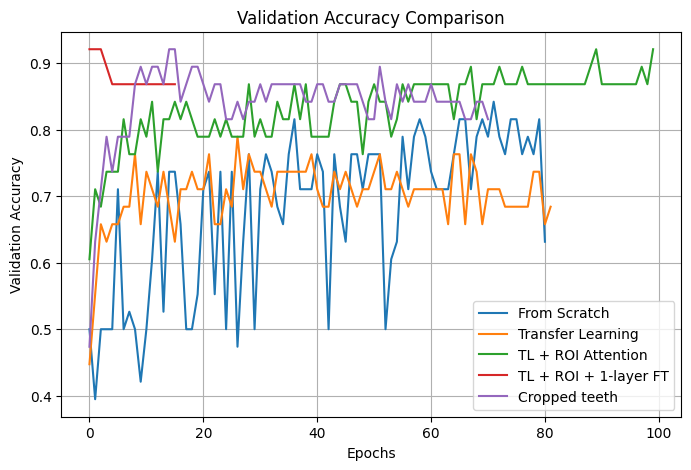

In [ ]:
def plot_val_comparison(histories, labels, title):
    plt.figure(figsize=(8, 5))

    for history, label in zip(histories, labels):
        plt.plot(history.history['val_accuracy'], label=label)

    plt.xlabel("Epochs")
    plt.ylabel("Validation Accuracy")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_val_comparison(
    histories=[
        history_1,
        history_2,
        history_attn,
        history_finetune,
        history_3
    ],
    labels=[
        "From Scratch",
        "Transfer Learning",
        "TL + ROI Attention",
        "TL + ROI + 1-layer FT",
        "Cropped teeth"
    ],
    title="Validation Accuracy Comparison"
)


5-Folds cross-validation for ROI attention model

In [ ]:
# --------------------------------
# 1️⃣ Prepare samples & labels
# --------------------------------
samples = train_gen_attn.samples
labels = np.array([s[2] for s in samples])  # label index

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
all_fold_metrics = []

# --------------------------------
# 2️⃣ 5-Fold CV
# --------------------------------
for fold, (train_idx, val_idx) in enumerate(skf.split(samples, labels)):
    print(f"\n🔁 Fold {fold + 1}/5")

    train_list = [samples[i] for i in train_idx]
    val_list   = [samples[i] for i in val_idx]

    # ✅ USE KEYWORD ARGUMENTS (THIS FIXES EVERYTHING)
    train_gen_fold = AttentionGuidedGenerator(
        data_source=train_list,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
        shuffle=True
    )

    val_gen_fold = AttentionGuidedGenerator(
        data_source=val_list,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
        shuffle=False
    )

    # --------------------------------
    # 3️⃣ Build & compile model
    # --------------------------------
    model, base_model = build_attention_model()
    model.compile(
        optimizer=Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # --------------------------------
    # 4️⃣ Train
    # --------------------------------
    model.fit(
        train_gen_fold,
        validation_data=val_gen_fold,
        epochs=50,
        verbose=1
    )

    # --------------------------------
    # 5️⃣ Evaluate
    # --------------------------------
    y_true, y_pred = [], []

    for i in range(len(val_gen_fold)):
        (x_img, x_mask), y = val_gen_fold[i]
        preds = (model.predict([x_img, x_mask], verbose=0) > 0.5).astype(int).flatten()

        y_true.extend(y)
        y_pred.extend(preds)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    acc  = (tp + tn) / (tp + tn + fp + fn)
    sens = tp / (tp + fn)

    print(f"Fold {fold + 1} - Accuracy: {acc:.4f}, Sensitivity: {sens:.4f}")
    all_fold_metrics.append((acc, sens))

# --------------------------------
# 6️⃣ Aggregate results
# --------------------------------
all_fold_metrics = np.array(all_fold_metrics)

print("\n✅ 5-Fold Cross-Validation Results:")
print(f"Accuracy:     {all_fold_metrics[:,0].mean():.4f} ± {all_fold_metrics[:,0].std():.4f}")
print(f"Sensitivity:  {all_fold_metrics[:,1].mean():.4f} ± {all_fold_metrics[:,1].std():.4f}")



🔁 Fold 1/5
Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 63s 870ms/step - accuracy: 0.6215 - loss: 0.6917 - val_accuracy: 0.6444 - val_loss: 0.6907
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.5808 - loss: 0.6903 - val_accuracy: 0.7333 - val_loss: 0.6641
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.6665 - loss: 0.6471 - val_accuracy: 0.7333 - val_loss: 0.6473
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.6940 - loss: 0.6091 - val_accuracy: 0.7111 - val_loss: 0.6280
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.7723 - loss: 0.5628 - val_accuracy: 0.7111 - val_loss: 0.6106
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.7813 - loss: 0.5446 - val_accuracy: 0.7333 - val_loss: 0.5989
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.7654 - loss: 0.5553 - val_accuracy: 0.7556 - val_loss: 0.5921
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.8107 - loss: 0.5100 - val_accu

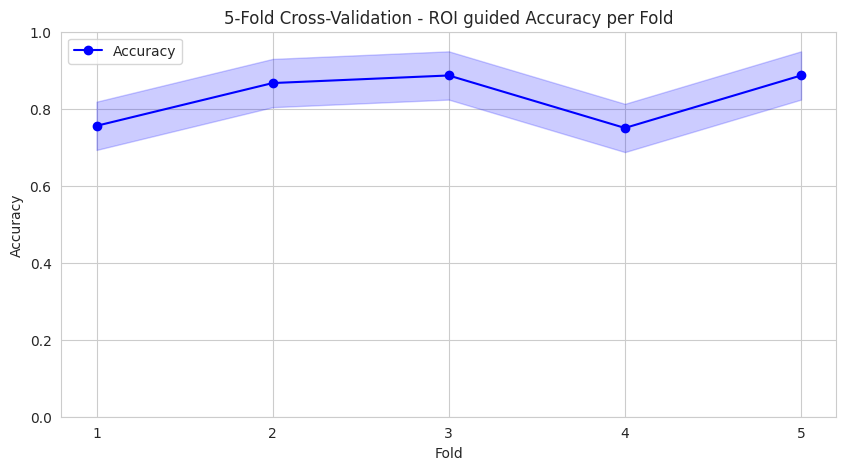

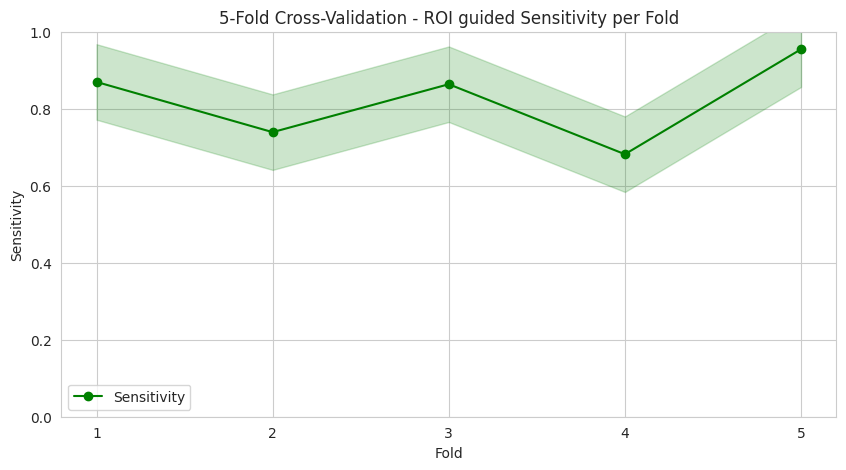

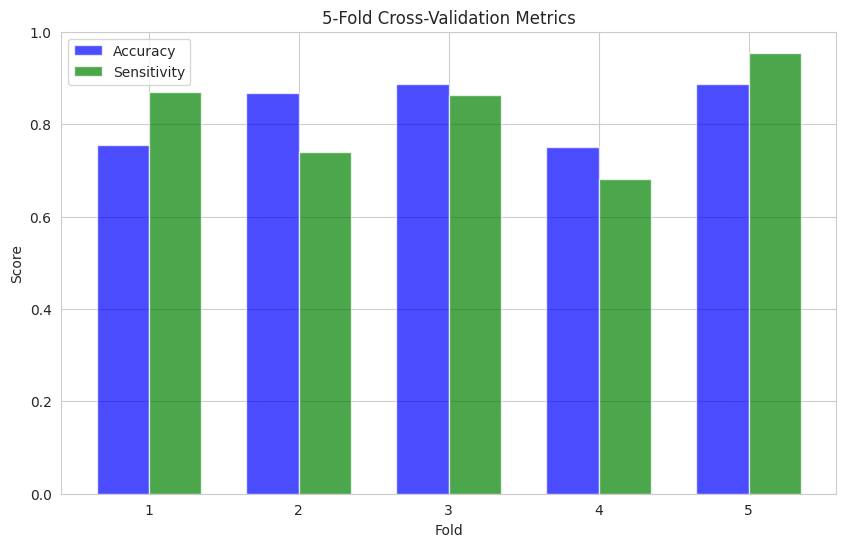

In [ ]:
# --------------------------------
# 1️⃣ Extract metrics
# --------------------------------
fold_numbers = np.arange(1, all_fold_metrics.shape[0] + 1)
accuracy = all_fold_metrics[:, 0]
sensitivity = all_fold_metrics[:, 1]

# --------------------------------
# 2️⃣ Plot Accuracy per Fold
# --------------------------------
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")

plt.plot(fold_numbers, accuracy, marker='o', linestyle='-', color='blue', label='Accuracy')
plt.fill_between(fold_numbers,
                 accuracy - accuracy.std(),
                 accuracy + accuracy.std(),
                 color='blue', alpha=0.2)

plt.xticks(fold_numbers)
plt.ylim(0, 1)
plt.title("5-Fold Cross-Validation - ROI guided Accuracy per Fold")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# --------------------------------
# 3️⃣ Plot Sensitivity per Fold
# --------------------------------
plt.figure(figsize=(10, 5))

plt.plot(fold_numbers, sensitivity, marker='o', linestyle='-', color='green', label='Sensitivity')
plt.fill_between(fold_numbers,
                 sensitivity - sensitivity.std(),
                 sensitivity + sensitivity.std(),
                 color='green', alpha=0.2)

plt.xticks(fold_numbers)
plt.ylim(0, 1)
plt.title("5-Fold Cross-Validation - ROI guided Sensitivity per Fold")
plt.xlabel("Fold")
plt.ylabel("Sensitivity")
plt.legend()
plt.show()

# --------------------------------
# 4️⃣ Optional: Combined Bar Plot
# --------------------------------
plt.figure(figsize=(10, 6))
bar_width = 0.35

plt.bar(fold_numbers - bar_width/2, accuracy, width=bar_width, color='blue', alpha=0.7, label='Accuracy')
plt.bar(fold_numbers + bar_width/2, sensitivity, width=bar_width, color='green', alpha=0.7, label='Sensitivity')

plt.xticks(fold_numbers)
plt.ylim(0, 1)
plt.title("5-Fold Cross-Validation Metrics")
plt.xlabel("Fold")
plt.ylabel("Score")
plt.legend()
plt.show()


5-Folds cross-validation for ROI cropped model

In [ ]:
# -------------------------------
# 1️⃣ Prepare samples & labels
# -------------------------------
# Use your existing generator to get filepaths & labels
filepaths = np.array(train_crop_data.filepaths)
labels = np.array(train_crop_data.classes)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
all_fold_metrics = []

# -------------------------------
# 2️⃣ 5-Fold CV
# -------------------------------
for fold, (train_idx, val_idx) in enumerate(skf.split(filepaths, labels), 1):
    print(f"\n🔁 Fold {fold}/5")

    train_files, train_labels = filepaths[train_idx], labels[train_idx]
    val_files, val_labels     = filepaths[val_idx], labels[val_idx]

    # -------------------------------
    # Custom generator for this fold
    # -------------------------------
    class CroppedGenerator(tf.keras.utils.Sequence):
        def __init__(self, filepaths, labels, batch_size, img_size, datagen):
            self.filepaths = filepaths
            self.labels = labels
            self.batch_size = batch_size
            self.img_size = img_size
            self.datagen = datagen
            self.indices = np.arange(len(self.filepaths))

        def __len__(self):
            return int(np.ceil(len(self.filepaths) / self.batch_size))

        def __getitem__(self, idx):
            batch_idx = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
            batch_x = np.array([tf.keras.utils.load_img(self.filepaths[i], target_size=self.img_size) for i in batch_idx])
            batch_x = np.array([tf.keras.utils.img_to_array(x) for x in batch_x])
            batch_y = np.array([self.labels[i] for i in batch_idx])
            return self.datagen.standardize(batch_x), batch_y

        def on_epoch_end(self):
            np.random.shuffle(self.indices)

    train_gen_fold = CroppedGenerator(train_files, train_labels, BATCH_SIZE, IMG_SIZE, train_crop_datagen)
    val_gen_fold   = CroppedGenerator(val_files, val_labels, BATCH_SIZE, IMG_SIZE, val_crop_datagen)

    # -------------------------------
    # Build & compile DenseNet model
    # -------------------------------
    def build_cropped_model():
        inputs = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
        base_model = DenseNet121(weights="imagenet", include_top=False, input_tensor=inputs)
        base_model.trainable = False
        x = GlobalAveragePooling2D()(base_model(inputs))
        x = Dense(128, activation="relu")(x)
        x = Dropout(0.5)(x)
        outputs = Dense(1, activation="sigmoid")(x)
        model = Model(inputs, outputs)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(1e-4),
            loss="binary_crossentropy",
            metrics=["accuracy"]
        )
        return model

    model = build_cropped_model()

    # -------------------------------
    # Train
    # -------------------------------
    model.fit(
        train_gen_fold,
        validation_data=val_gen_fold,
        epochs=50,
        verbose=1
    )

    # -------------------------------
    # Evaluate
    # -------------------------------
    y_true, y_pred = [], []
    for i in range(len(val_gen_fold)):
        x, y = val_gen_fold[i]
        preds = (model.predict(x, verbose=0) > 0.5).astype(int).flatten()
        y_true.extend(y)
        y_pred.extend(preds)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    acc  = (tp + tn) / (tp + tn + fp + fn)
    sens = tp / (tp + fn)
    print(f"Fold {fold} → Accuracy: {acc:.4f}, Sensitivity: {sens:.4f}")

    all_fold_metrics.append((acc, sens))

# -------------------------------
# 3️⃣ Aggregate results
# -------------------------------
all_fold_metrics = np.array(all_fold_metrics)
print("\n✅ 5-Fold Cross-Validation Results – Cropped DenseNet")
print(f"Accuracy:    {all_fold_metrics[:,0].mean():.4f} ± {all_fold_metrics[:,0].std():.4f}")
print(f"Sensitivity:{all_fold_metrics[:,1].mean():.4f} ± {all_fold_metrics[:,1].std():.4f}")



🔁 Fold 1/5
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/45 ━━━━━━━━━━━━━━━━━━━━ 57s 739ms/step - accuracy: 0.4791 - loss: 0.7543 - val_accuracy: 0.6667 - val_loss: 0.6558
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.5719 - loss: 0.6730 - val_accuracy: 0.7111 - val_loss: 0.6051
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.5684 - loss: 0.6857 - val_accuracy: 0.6889 - val_loss: 0.5752
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7344 - loss: 0.5496 - val_accuracy: 0.7556 - val_loss: 0.5529
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7352 - loss: 0.5518 - val_accuracy: 0.8000 - val_loss: 0.5352
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7586 - loss: 0.5187 - val_accuracy: 0.7778 - val_loss: 0.5156
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7735 - loss: 0.5019 - val_accuracy: 0.8222 - val_loss: 0.5026
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7468 - loss: 0.4829 - val_accuracy: 0.8000 - val_loss: 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/45 ━━━━━━━━━━━━━━━━━━━━ 57s 710ms/step - accuracy: 0.5206 - loss: 0.7736 - val_accuracy: 0.6889 - val_loss: 0.6255
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6288 - loss: 0.6734 - val_accuracy: 0.7111 - val_loss: 0.5904
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6178 - loss: 0.6774 - val_accuracy: 0.7111 - val_loss: 0.5638
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7405 - loss: 0.5584 - val_accuracy: 0.7111 - val_loss: 0.5481
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7297 - loss: 0.5822 - val_accuracy: 0.7333 - val_loss: 0.5332
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.8008 - loss: 0.4770 - val_accuracy: 0.7111 - val_loss: 0.5185
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7987 - loss: 0.4744 - val_accuracy: 0.6889 - val_loss: 0.5062
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7795 - loss: 0.4444 - val_accuracy: 0.7111 - val_loss: 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/45 ━━━━━━━━━━━━━━━━━━━━ 49s 579ms/step - accuracy: 0.5428 - loss: 0.7520 - val_accuracy: 0.6591 - val_loss: 0.6531
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5462 - loss: 0.7114 - val_accuracy: 0.6818 - val_loss: 0.6145
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5659 - loss: 0.6765 - val_accuracy: 0.7273 - val_loss: 0.5825
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6155 - loss: 0.6170 - val_accuracy: 0.7045 - val_loss: 0.5677
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.7243 - loss: 0.5509 - val_accuracy: 0.7273 - val_loss: 0.5634
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6938 - loss: 0.5488 - val_accuracy: 0.6818 - val_loss: 0.5449
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7667 - loss: 0.4645 - val_accuracy: 0.7273 - val_loss: 0.5203
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7795 - loss: 0.4778 - val_accuracy: 0.7500 - val_loss: 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/45 ━━━━━━━━━━━━━━━━━━━━ 49s 566ms/step - accuracy: 0.4244 - loss: 0.9277 - val_accuracy: 0.5909 - val_loss: 0.6517
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5567 - loss: 0.6896 - val_accuracy: 0.7273 - val_loss: 0.5986
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6610 - loss: 0.6454 - val_accuracy: 0.8182 - val_loss: 0.5636
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.6895 - loss: 0.5966 - val_accuracy: 0.7955 - val_loss: 0.5314
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7039 - loss: 0.5482 - val_accuracy: 0.7727 - val_loss: 0.5135
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7984 - loss: 0.5225 - val_accuracy: 0.7955 - val_loss: 0.4863
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7399 - loss: 0.5143 - val_accuracy: 0.8182 - val_loss: 0.4737
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7732 - loss: 0.4973 - val_accuracy: 0.8182 - val_loss: 

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/45 ━━━━━━━━━━━━━━━━━━━━ 65s 776ms/step - accuracy: 0.5027 - loss: 0.7881 - val_accuracy: 0.5909 - val_loss: 0.6753
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5998 - loss: 0.6755 - val_accuracy: 0.7045 - val_loss: 0.6132
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.5815 - loss: 0.6437 - val_accuracy: 0.7045 - val_loss: 0.5700
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.7054 - loss: 0.5933 - val_accuracy: 0.7727 - val_loss: 0.5348
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8407 - loss: 0.5227 - val_accuracy: 0.7955 - val_loss: 0.5060
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.7226 - loss: 0.5327 - val_accuracy: 0.8636 - val_loss: 0.4806
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.7684 - loss: 0.5101 - val_accuracy: 0.8409 - val_loss: 0.4604
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.8120 - loss: 0.4702 - val_accuracy: 0.8636 - val_loss: 0

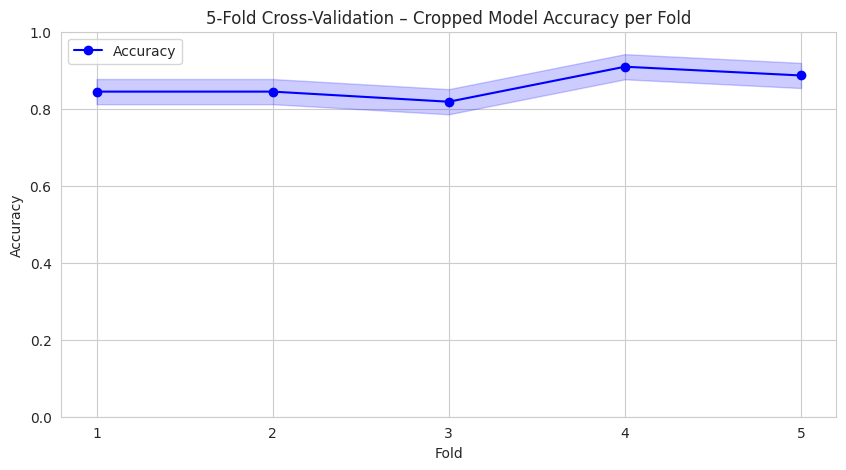

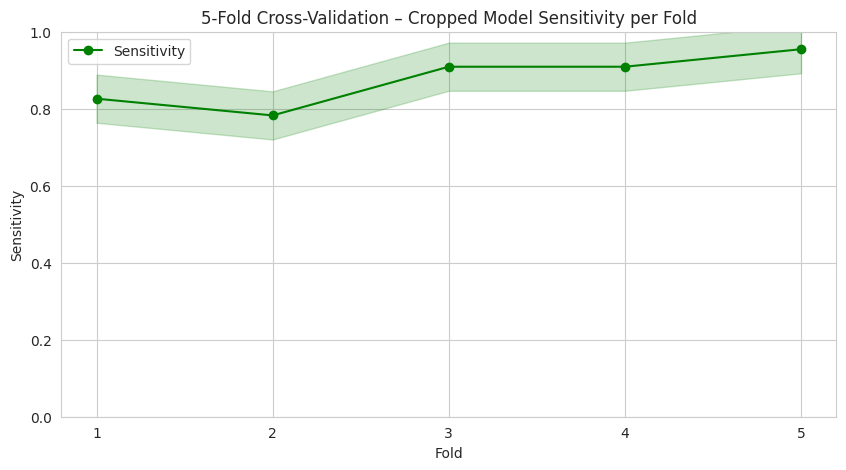

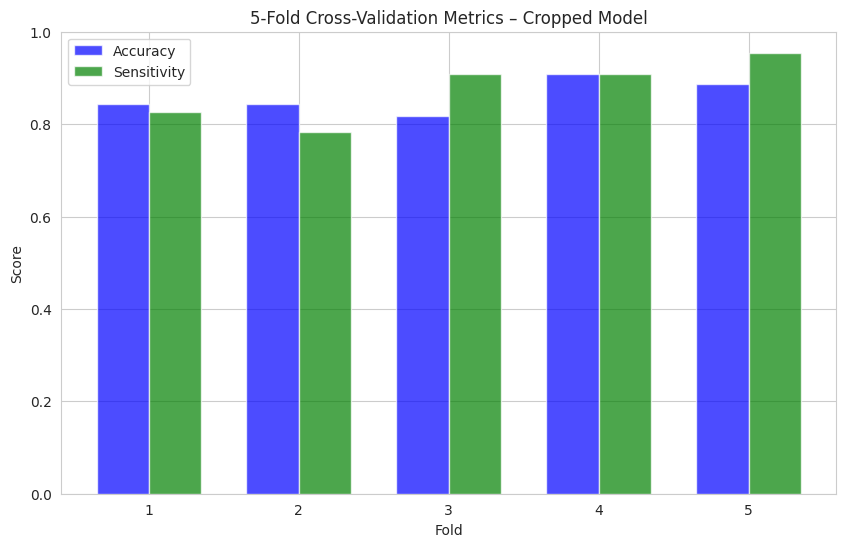

In [ ]:
# --------------------------------
# 1️⃣ Extract metrics
# --------------------------------
fold_numbers = np.arange(1, all_fold_metrics.shape[0] + 1)
accuracy = all_fold_metrics[:, 0]
sensitivity = all_fold_metrics[:, 1]

# --------------------------------
# 2️⃣ Plot Accuracy per Fold
# --------------------------------
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")

plt.plot(fold_numbers, accuracy, marker='o', linestyle='-', color='blue', label='Accuracy')
plt.fill_between(
    fold_numbers,
    accuracy - accuracy.std(),
    accuracy + accuracy.std(),
    color='blue',
    alpha=0.2
)

plt.xticks(fold_numbers)
plt.ylim(0, 1)
plt.title("5-Fold Cross-Validation – Cropped Model Accuracy per Fold")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# --------------------------------
# 3️⃣ Plot Sensitivity per Fold
# --------------------------------
plt.figure(figsize=(10, 5))

plt.plot(fold_numbers, sensitivity, marker='o', linestyle='-', color='green', label='Sensitivity')
plt.fill_between(
    fold_numbers,
    sensitivity - sensitivity.std(),
    sensitivity + sensitivity.std(),
    color='green',
    alpha=0.2
)

plt.xticks(fold_numbers)
plt.ylim(0, 1)
plt.title("5-Fold Cross-Validation – Cropped Model Sensitivity per Fold")
plt.xlabel("Fold")
plt.ylabel("Sensitivity")
plt.legend()
plt.show()

# --------------------------------
# 4️⃣ Optional: Combined Bar Plot
# --------------------------------
plt.figure(figsize=(10, 6))
bar_width = 0.35

plt.bar(
    fold_numbers - bar_width / 2,
    accuracy,
    width=bar_width,
    color='blue',
    alpha=0.7,
    label='Accuracy'
)

plt.bar(
    fold_numbers + bar_width / 2,
    sensitivity,
    width=bar_width,
    color='green',
    alpha=0.7,
    label='Sensitivity'
)

plt.xticks(fold_numbers)
plt.ylim(0, 1)
plt.title("5-Fold Cross-Validation Metrics – Cropped Model")
plt.xlabel("Fold")
plt.ylabel("Score")
plt.legend()
plt.show()


Confusion matrix for the 80% guided ROI attention combined with 20% usual model learning

In [ ]:
def get_confusion_data(model, generator, threshold=0.5):
    y_true = []
    y_pred = []

    n_inputs = len(model.inputs)  # 🔑 detects 1-input vs 2-input model

    for i in range(len(generator)):
        (x_imgs, x_masks), batch_labels = generator[i]

        if n_inputs == 1:
            preds_probs = model.predict(x_imgs, verbose=0)
        elif n_inputs == 2:
            preds_probs = model.predict([x_imgs, x_masks], verbose=0)
        else:
            raise ValueError(f"Unsupported number of model inputs: {n_inputs}")

        batch_preds = (preds_probs > threshold).astype(int).flatten()

        y_true.extend(batch_labels)
        y_pred.extend(batch_preds)

    return np.array(y_true), np.array(y_pred)


def plot_confusion_comparison(models, generator, labels, title, threshold=0.5):
    plt.figure(figsize=(5 * len(models), 5))

    for i, (model, label) in enumerate(zip(models, labels)):
        y_true, y_pred = get_confusion_data(model, generator, threshold)
        cm = confusion_matrix(y_true, y_pred)

        plt.subplot(1, len(models), i + 1)
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=['Normal', 'Problem'],
            yticklabels=['Normal', 'Problem']
        )

        plt.title(label)
        plt.xlabel("Predicted")
        if i == 0:
            plt.ylabel("True")
        else:
            plt.ylabel("")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


def print_classification_reports(models, labels, generator, threshold=0.5):
    for model, label in zip(models, labels):
        y_true, y_pred = get_confusion_data(model, generator, threshold)

        print(f"\n===== {label} =====")
        print(classification_report(
            y_true,
            y_pred,
            target_names=['Normal', 'Problem']
        ))



In [ ]:
plot_confusion_comparison(
    models=[
        model_1,
        model_2,
        attention_model
    ],
    generator=test_gen_attn,
    labels=[
        "From Scratch",
        "Transfer Learning",
        "TL + ROI Attention"
    ],
    title="Confusion Matrix Comparison (Test Set)"
)

print_classification_reports(
    models=[
        model_1,
        model_2,
        attention_model
    ],
    labels=[
        "From Scratch",
        "Transfer Learning",
        "TL + ROI Attention"
    ],
    generator=test_gen_attn
)
